In [1]:
#import packages
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
import rtree  # supports geospatial join
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
import sys
import pickle
from shapely.ops import nearest_points
from datetime import datetime as dt, date
sys.path.append('/Users/jackepstein/Documents/GitHub/wildfires-1001/code/functions/')
from modeling_functions import *
data_dir = '/Users/jackepstein/Documents/GitHub/wildfires-1001/data'
code_dir = '/Users/jackepstein/Documents/GitHub/wildfires-1001/code'
model_dir = '/Users/jackepstein/Documents/GitHub/wildfires-1001/models'

In [2]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, multilabel_confusion_matrix
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import scale, label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA

# Pull in main data frame

In [3]:
#pull in the target data frame and weather dictionary 
#make sure to change the pkl file name if needed
target_dict = {}
target_df = gpd.GeoDataFrame()
for i in np.arange(1, 3):
    target_dict[i] = pd.read_pickle(os.path.join(data_dir, f'clean_data/target_df_final_1123_newtargets_{i}.pkl')) 
    target_df = target_df.append(target_dict[i])


weather_dict_path = os.path.join(data_dir, 'clean_data/ERA_weather-data/ERA_rename_dictionary.pkl')

In [4]:
#load the naming dictionary
with open(weather_dict_path, 'rb') as handle:
    rename_dict = pickle.load(handle)

In [5]:
#rename the columns based on this dictionary
target_df.rename(columns = rename_dict, inplace = True)

In [6]:
#create lists of columns to drop and what our targets are
non_mod_cols = ['GRID_ID','month_id','MONTH','COUNTYFP','COUNTY_AREA', 'NAME','GRID_AREA','COUNTY_ARE','month_id_old_x','month_id_old_y',
                'geometry','Fire_area','total_fire_days','hist_p_time_1y','total_fire_days','hist_p_time_1y', 
                'hist_p_time_1m', 'month_id_old', 'YEAR','Index','index']
bad_features = ['hist_p_time_1m', 'total_fire_days', 'hist_p_time_1y','month_id_old']
Y_cols = ['Y_bin', 'Y_fire_count', 'Y_fire_area_prop', 'Y_fire_class_size','Y_bin_new_fire_month',
          'Y_max_new_fire_size_month','Y_count_new_fires_month']

In [7]:
#convert floats from 64 to 32 for model
for col in target_df.columns:
    if target_df[col].dtypes == 'float64':
        target_df[col] = target_df[col].astype(np.float32)

# Pull in Models and Feature Lists

In [8]:
#pull in models

#list of models
model_list = ['LR_15PCA_1990_2015.pkl', 'LR_30entropy_1990_2015.pkl', 'linSVC_25PCA_1990_2015.pkl', 
              'LR_15PCA_1990_2005.pkl', 'LR_20gini_1990_2005.pkl', 'linSVC_15PCA_1990_2005.pkl', 
              'linSVC_30gini_1990_2005.pkl', 'linSVC_35entropy_1990_2015.pkl']


#get all paths for loading
model_path_list = []
for m in model_list:
    mod_path = os.path.join(model_dir, m)
    model_path_list.append(mod_path)

#load the models into a dictionary with the file as the key and the model as the value
models = {}
for m in range(len(model_list)):
    with open(model_path_list[m], 'rb') as handle:
        models[model_list[m]] = pickle.load(handle)

In [9]:
#pull in feature lists

#w ill need 30e
feat_list = ['RF_entropy_top30_features.pkl', 'RF_gini_top20_features_1990_2005.pkl', 
             'RF_gini_top30_features_1990_2005.pkl', 'RF_entropy_top35_features.pkl']

#get paths for loading
feat_path_list = []
for f in feat_list:
    feat_path = os.path.join(model_dir,'feature_lists',f)
    feat_path_list.append(feat_path)

features = {}
for f in range(len(feat_list)):
    with open(feat_path_list[f], 'rb') as handle:
        features[feat_list[f]] = pickle.load(handle)

# Split training and testing data

### This is the split where using the 1990-2005 on initial test, 2006-2015 on 2nd stage and 2016-2019 on final testing

In [10]:
#generate phase1 data set
#pre 2006
phase1_data = target_df[target_df['YEAR']<2006]
X_phase1 = phase1_data.drop('YEAR', axis = 1)
#drop columns not used for modeling - dont drop Ys here
for y in Y_cols + non_mod_cols + bad_features:
    try:
        X_phase1.drop(y, inplace = True, axis =1)
    except:
        pass
#set up target variable
Y_ph1_cl = phase1_data[['Y_bin_new_fire_month']]
Y_ph1_cl_size = phase1_data[['Y_max_new_fire_size_month']]

#generate phase2 data set - same logic as above
phase2_data = target_df[(target_df['YEAR']>=2006)&(target_df['YEAR']<2016)]
X_phase2 = phase2_data.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols + bad_features:
    try:
        X_phase2.drop(y, inplace = True, axis =1)
    except:
        pass
Y_ph2_cl = phase2_data[['Y_bin_new_fire_month']]
Y_ph2_cl_size = phase2_data[['Y_max_new_fire_size_month']]

#generate phase3 (test) data set
phase3_data = target_df[target_df['YEAR']>=2016]
X_phase3 = phase3_data.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols + bad_features:
    try:
        X_phase3.drop(y, inplace = True, axis =1)
    except:
        pass
Y_ph3_cl = phase3_data[['Y_bin_new_fire_month']]
Y_ph3_cl_size = phase3_data[['Y_max_new_fire_size_month']]

In [11]:
#scale all data sets
X_phase1_scaled = pd.DataFrame(scale(X_phase1), columns = X_phase1.columns, index=X_phase1.index)
X_phase2_scaled = pd.DataFrame(scale(X_phase2), columns = X_phase2.columns, index=X_phase2.index)
X_phase3_scaled = pd.DataFrame(scale(X_phase3), columns = X_phase3.columns, index=X_phase3.index)

# Perform PCA

In [12]:
#copy base df and re-drop non modeling columns
X_features = target_df.copy()
for y in Y_cols + non_mod_cols + bad_features:
    try:
        X_features.drop(y, inplace = True, axis =1)
    except:
        pass
    
#scale features    
X_features_scaled = scale(X_features)    

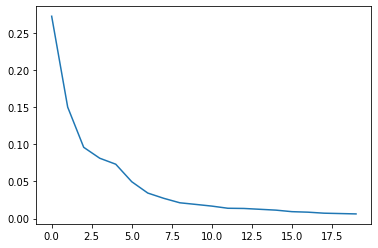

In [13]:
#fit the scaled dataset
pca_x = PCA().fit(X_features_scaled)

#plot explained variance ratio
plt.plot(pca_x.explained_variance_ratio_[0:20])

In [14]:
pca_df = pd.DataFrame(pca_x.components_[0:20,].transpose(), columns = ["PC{}".format(i+1) for i in range(20)], \
                      index = X_features.columns)

In [15]:
#write for loop to make list "nth_principle_component"
princ_comp_list = []
for name in range(1,173):
    pr = str(name)+'th_pc'
    princ_comp_list.append(pr)    

In [16]:
#do split on 3 phases -- still need to do 3 phase split as well
X_features_pca = pd.DataFrame(pca_x.transform(X_features_scaled), columns = princ_comp_list)
X_features_pca['YEAR'] = target_df['YEAR']

#split phases on year
X_ph1_pca = X_features_pca[X_features_pca['YEAR']< 2006]
X_ph2_pca = X_features_pca[(X_features_pca['YEAR']>=2006)&(X_features_pca['YEAR']<2016)]
X_ph3_pca = X_features_pca[X_features_pca['YEAR']>=2016]


Y_ph1_pca = target_df[target_df['YEAR']<2006]['Y_bin_new_fire_month']
Y_ph1_size_pca = target_df[target_df['YEAR']<2006]['Y_max_new_fire_size_month']

Y_ph2_pca = target_df[(target_df['YEAR']>=2006)&(target_df['YEAR']<2016)]['Y_bin_new_fire_month']
Y_ph2_size_pca = target_df[(target_df['YEAR']>=2006)&(target_df['YEAR']<2016)]['Y_max_new_fire_size_month']

Y_ph3_pca = target_df[target_df['YEAR']>=2016]['Y_bin_new_fire_month']
Y_ph3_size_pca = target_df[target_df['YEAR']>=2016]['Y_max_new_fire_size_month']

## Pick model and Get Trained Predictions

ASPECTS TO TEST
- LR vs SVM
- REGULARIZATION PARAMETERS
- PCA vs DATA
- Number of Features/Principle Components
- Try one test with Predictions as a feature rather than a filtering device

In [17]:
#pick model
#picking SVM 'linSVC_15PCA_1990_2005.pkl'
#same AUC as LR model, higher recall
model = models['linSVC_15PCA_1990_2005.pkl']
model

LinearSVC(C=0.0001, class_weight='balanced', dual=False)

In [18]:
#slim down features
X_ph1_15 = X_ph1_pca[X_ph1_pca.columns[0:15]]
X_ph2_15 = X_ph2_pca[X_ph2_pca.columns[0:15]]
X_ph3_15 = X_ph3_pca[X_ph3_pca.columns[0:15]]

In [19]:
#run model on train and test sets to get predictions
y_preds_ph2 = model.predict(X_ph2_15)
y_preds_ph3 = model.predict(X_ph3_15)

In [21]:
#store predictions and filter -- phase 2

#append the these predictions to the dataframe
preds2_df = pd.DataFrame(y_preds_ph2, columns=['preds'], index=X_ph2_pca.index)
X_ph2_pca_preds = X_ph2_pca.merge(preds2_df, how='outer', left_index=True, right_index=True)

#rejoin with the y-size column
X_ph2_pca_ysize = X_ph2_pca_preds.merge(Y_ph2_size_pca, how='outer', left_index=True, right_index=True)



#store predictions and filter -- phase 3

#append the these predictions to the dataframe
preds3_df = pd.DataFrame(y_preds_ph3, columns=['preds'], index=X_ph3_pca.index)
X_ph3_pca_preds = X_ph3_pca.merge(preds3_df, how='outer', left_index=True, right_index=True)

#rejoin with the y-size column
X_ph3_pca_ysize = X_ph3_pca_preds.merge(Y_ph3_size_pca, how='outer', left_index=True, right_index=True)

In [22]:
#repeat this process for the standard scaled data set

#append the these predictions to the dataframe
preds2_df2 = pd.DataFrame(y_preds_ph2, columns=['preds'], index=X_phase2_scaled.index)
X_ph2_scaled_preds = X_phase2_scaled.merge(preds2_df2, how='outer', left_index=True, right_index=True)

#rejoin with the y-size column
X_ph2_scaled_ysize = X_ph2_scaled_preds.merge(Y_ph2_cl_size, how='outer', left_index=True, right_index=True)



#store predictions and filter -- phase 3

#append the these predictions to the dataframe
preds3_df2 = pd.DataFrame(y_preds_ph3, columns=['preds'], index=X_phase3_scaled.index)
X_ph3_scaled_preds = X_phase3_scaled.merge(preds3_df2, how='outer', left_index=True, right_index=True)

#rejoin with the y-size column
X_ph3_scaled_ysize = X_ph3_scaled_preds.merge(Y_ph3_cl_size, how='outer', left_index=True, right_index=True)

# Using positive predictions as a filter (rather than a feature)

#### Get test and training sets and targets ready

In [23]:
#filter for the positive predicted instances
X_ph2_pca_cut = X_ph2_pca_ysize.loc[X_ph2_pca_ysize['preds']==1]
X_ph3_pca_cut = X_ph3_pca_ysize.loc[X_ph3_pca_ysize['preds']==1]
X_ph2_scaled_cut = X_ph2_scaled_ysize.loc[X_ph2_scaled_ysize['preds']==1]
X_ph3_scaled_cut = X_ph3_scaled_ysize.loc[X_ph3_scaled_ysize['preds']==1]


#drop preds and class_size columns, while saving class size as a new training y
Y_ph2_size_pca_cut = X_ph2_pca_cut['Y_max_new_fire_size_month']
Y_ph3_size_pca_cut = X_ph3_pca_cut['Y_max_new_fire_size_month']
Y_ph2_scaled_cut = X_ph2_scaled_cut['Y_max_new_fire_size_month']
Y_ph3_scaled_cut = X_ph3_scaled_cut['Y_max_new_fire_size_month']

X_ph2_pca_ready = X_ph2_pca_cut.drop(columns=['preds','Y_max_new_fire_size_month','YEAR'])
X_ph3_pca_ready = X_ph3_pca_cut.drop(columns=['preds','Y_max_new_fire_size_month','YEAR'])
X_ph2_scaled_ready = X_ph2_scaled_cut.drop(columns=['preds','Y_max_new_fire_size_month'])
X_ph3_scaled_ready = X_ph3_scaled_cut.drop(columns=['preds','Y_max_new_fire_size_month'])

In [24]:
#regularization hyperparam options
cs = [10**i for i in range(-4, 2)] 
pc_nums = [15, 20, 25, 30]
classes = np.array([0,1,2,3])
costs = np.array([0, -1, -10 , -50])

In [25]:
#get the cost matrix
cost_mat = multi_cost_matrix(classes, costs)
cost_mat

array([[  0.   ,  -0.25 ,  -2.5  , -12.5  ],
       [ -1.   ,   0.   ,  -0.225,  -0.245],
       [-10.   ,  -0.9  ,   0.   ,  -0.2  ],
       [-50.   ,  -0.98 ,  -0.8  ,   0.   ]])

In [121]:
colummns_top = ['test', 'EV', 'AUC', 'Recall_bf']
top_score_df = pd.DataFrame(columns=colummns_top)

# Test 1: Logistic Regression - PCA
- Regularization params
- Number of Principle Components

In [26]:
#run LR on all Cs and number of PCs
#store all confusion matrices, AUCs, scores and expected values
aucs_t1 = {}
conf_mats_t1 = {}
evs_t1 = {}

for i in pc_nums:
    #slim down data set to first i PCs
    X_ph2_pca_fit = X_ph2_pca_ready[X_ph2_pca_ready.columns[0:i]]
    X_ph3_pca_score = X_ph3_pca_ready[X_ph3_pca_ready.columns[0:i]]
    
    #create nested dictionary 
    aucs_t1[i] = {}
    conf_mats_t1[i] = {}
    evs_t1[i] = {}
    
    for c in cs:
        lr = LogisticRegression(C=c, max_iter=1500, class_weight = 'balanced').fit(X_ph2_pca_fit, 
                                                                                   Y_ph2_size_pca_cut.to_numpy().ravel())

        cm = confusion_matrix(Y_ph3_size_pca_cut, lr.predict(X_ph3_pca_score), normalize='true')
        conf_mats_t1[i][c] = cm
        ev = EV_multi(Y_ph3_size_pca_cut, lr.predict(X_ph3_pca_score), classes, cost_mat)
        evs_t1[i][c] = ev
        
        #store aucs -- will aggregate after taking an auc for each class -- simple mean
        y = label_binarize(Y_ph3_size_pca_cut, classes=[0,1,2,3])
        n_classes = y.shape[1]
        aucs_sub = np.zeros(n_classes)
        for n in range(n_classes):
            fpr, tpr, thresholds = roc_curve(y[:,n], lr.predict_proba(X_ph3_pca_score)[:,n])
            aucs_sub = auc(fpr,tpr)
    
        aucs_t1[i][c] = np.mean(aucs_sub)

In [71]:
#get the best expected value from the test
max_evs_t1 = []
max_keys_t1 = []
for d in pc_nums:
    max_ev = max(evs_t1[d].values())
    max_key = max(evs_t1[d], key=evs_t1[d].get)
    max_evs_t1.append(max_ev)
    max_keys_t1.append(max_key)

index_t1 = max_evs_t1.index(max(max_evs_t1)) 
print("# of princtple components for max EV:",pc_nums[index_t1])    
print("regularization weight for max EV:",max_keys_t1[index_t1])
print("Max EV:",max_evs_t1[index_t1])

# of princtple components for max EV: 25
regularization weight for max EV: 0.01
Max EV: -2.785930161214157


In [122]:
#for above params, get the AUC, EV and big fire recall
top_score_df
temp_df = pd.DataFrame([['t1',max_evs_t1[index_t1],
                         aucs_t1[pc_nums[index_t1]][max_keys_t1[index_t1]],
                         conf_mats_t1[pc_nums[index_t1]][max_keys_t1[index_t1]][3][3]]], columns=colummns_top)
top_score_df = top_score_df.append(temp_df)

,test,EV,AUC,Recall_bf
0,t1,-2.78593,0.703809,0.481481


# Test 2: SVM - PCA
- Regularization params
- Number of Principle Components

In [28]:
#run SVM on all Cs and number of PCs
#store all confusion matrices, AUCs, scores and expected values
aucs_t2 = {}
conf_mats_t2 = {}
evs_t2 = {}

for i in pc_nums:
    #slim down data set to first i PCs
    X_ph2_pca_fit = X_ph2_pca_ready[X_ph2_pca_ready.columns[0:i]]
    X_ph3_pca_score = X_ph3_pca_ready[X_ph3_pca_ready.columns[0:i]]
    
    #create nested dictionary 
    aucs_t2[i] = {}
    conf_mats_t2[i] = {}
    evs_t2[i] = {}
    
    for c in cs:
        svm = LinearSVC(C=c, class_weight = 'balanced', dual=False).fit(X_ph2_pca_fit, 
                                                                                   Y_ph2_size_pca_cut.to_numpy().ravel())

        cm = confusion_matrix(Y_ph3_size_pca_cut, svm.predict(X_ph3_pca_score), normalize='true')
        conf_mats_t2[i][c] = cm
        ev = EV_multi(Y_ph3_size_pca_cut, svm.predict(X_ph3_pca_score), classes, cost_mat)
        evs_t2[i][c] = ev
        
        #store aucs -- will aggregate after taking an auc for each class -- simple mean
        y = label_binarize(Y_ph3_size_pca_cut, classes=[0,1,2,3])
        n_classes = y.shape[1]
        aucs_sub = np.zeros(n_classes)
        for n in range(n_classes):
            fpr, tpr, thresholds = roc_curve(y[:,n], svm.decision_function(X_ph3_pca_score)[:,n])
            aucs_sub = auc(fpr,tpr)
    
        aucs_t2[i][c] = np.mean(aucs_sub)

In [72]:
#get the best expected value from the test
max_evs_t2 = []
max_keys_t2 = []
for d in pc_nums:
    max_ev = max(evs_t2[d].values())
    max_key = max(evs_t2[d], key=evs_t2[d].get)
    max_evs_t2.append(max_ev)
    max_keys_t2.append(max_key)

index_t2 = max_evs_t2.index(max(max_evs_t2)) 
print("# of princtple components for max EV:",pc_nums[index_t2])    
print("regularization weight for max EV:",max_keys_t2[index_t2])
print("Max EV:",max_evs_t2[index_t2])

# of princtple components for max EV: 20
regularization weight for max EV: 1
Max EV: -6.933039702643486


In [123]:
#for above params, get the AUC, EV and big fire recall
temp_df = pd.DataFrame([['t2',max_evs_t2[index_t2],
                         aucs_t2[pc_nums[index_t2]][max_keys_t2[index_t2]],
                         conf_mats_t2[pc_nums[index_t2]][max_keys_t2[index_t2]][3][3]]], columns=colummns_top)
top_score_df = top_score_df.append(temp_df)

,test,EV,AUC,Recall_bf
0,t1,-2.78593,0.703809,0.481481
0,t2,-6.93304,0.732259,0.282407


# Test 3: Logistic Regression - Feature Selection

- Regularization params
- Features (can pick from list)

In [30]:
feat_list_keys = list(features.keys())

In [31]:
#run LR on all Cs and features
#store all confusion matrices, AUCs, scores and expected values
aucs_t3 = {}
conf_mats_t3 = {}
evs_t3 = {}

for i in feat_list_keys:
    #slim down data set our top features
    X_ph2_feat_fit = X_ph2_scaled_ready[features[i]]
    X_ph3_feat_score = X_ph3_scaled_ready[features[i]]
    
    #create nested dictionary 
    aucs_t3[i] = {}
    conf_mats_t3[i] = {}
    evs_t3[i] = {}
    
    for c in cs:
        lr = LogisticRegression(C=c, max_iter=1500, class_weight = 'balanced').fit(X_ph2_feat_fit, 
                                                                                   Y_ph2_scaled_cut.to_numpy().ravel())

        cm = confusion_matrix(Y_ph3_scaled_cut, lr.predict(X_ph3_feat_score), normalize='true')
        conf_mats_t3[i][c] = cm
        ev = EV_multi(Y_ph3_scaled_cut, lr.predict(X_ph3_feat_score), classes, cost_mat)
        evs_t3[i][c] = ev
        
        #store aucs -- will aggregate after taking an auc for each class -- simple mean
        y = label_binarize(Y_ph3_scaled_cut, classes=[0,1,2,3])
        n_classes = y.shape[1]
        aucs_sub = np.zeros(n_classes)
        for n in range(n_classes):
            fpr, tpr, thresholds = roc_curve(y[:,n], lr.predict_proba(X_ph3_feat_score)[:,n])
            aucs_sub = auc(fpr,tpr)
    
        aucs_t3[i][c] = np.mean(aucs_sub)

In [78]:
#get the best expected value from the test
max_evs_t3 = []
max_keys_t3 = []
for f in feat_list_keys:
    max_ev = max(evs_t3[f].values())
    max_key = max(evs_t3[f], key=evs_t3[f].get)
    max_evs_t3.append(max_ev)
    max_keys_t3.append(max_key)

index_t3 = max_evs_t3.index(max(max_evs_t3)) 
print("Feature list for max EV:",feat_list_keys[index_t3])    
print("regularization weight for max EV:",max_keys_t3[index_t3])
print("Max EV:",max_evs_t3[index_t3])

Feature list for max EV: RF_entropy_top35_features.pkl
regularization weight for max EV: 0.001
Max EV: -2.5454706434438066


In [126]:
#for above params, get the AUC, EV and big fire recall
temp_df = pd.DataFrame([['t3',max_evs_t3[index_t3],
                         aucs_t3[feat_list_keys[index_t3]][max_keys_t3[index_t3]],
                         conf_mats_t3[feat_list_keys[index_t3]][max_keys_t3[index_t3]][3][3]]], columns=colummns_top)
top_score_df = top_score_df.append(temp_df)

# Test 4: SVM- Feature Selection

- Regularization params
- Features (can pick from list)

In [33]:
#run SVM on all Cs and features
#store all confusion matrices, AUCs, scores and expected values
aucs_t4 = {}
conf_mats_t4 = {}
evs_t4 = {}

for i in feat_list_keys:
    #slim down data set our top features
    X_ph2_feat_fit = X_ph2_scaled_ready[features[i]]
    X_ph3_feat_score = X_ph3_scaled_ready[features[i]]
    
    #create nested dictionary 
    aucs_t4[i] = {}
    conf_mats_t4[i] = {}
    evs_t4[i] = {}
    
    for c in cs:
        svm = LinearSVC(C=c, class_weight = 'balanced', dual=False).fit(X_ph2_feat_fit, 
                                                                                   Y_ph2_scaled_cut.to_numpy().ravel())

        cm = confusion_matrix(Y_ph3_scaled_cut, svm.predict(X_ph3_feat_score), normalize='true')
        conf_mats_t4[i][c] = cm
        ev = EV_multi(Y_ph3_scaled_cut, svm.predict(X_ph3_feat_score), classes, cost_mat)
        evs_t4[i][c] = ev
        
        #store aucs -- will aggregate after taking an auc for each class -- simple mean
        y = label_binarize(Y_ph3_scaled_cut, classes=[0,1,2,3])
        n_classes = y.shape[1]
        aucs_sub = np.zeros(n_classes)
        for n in range(n_classes):
            fpr, tpr, thresholds = roc_curve(y[:,n], svm.decision_function(X_ph3_feat_score)[:,n])
            aucs_sub = auc(fpr,tpr)
    
        aucs_t4[i][c] = np.mean(aucs_sub)

In [80]:
#get the best expected value from the test
max_evs_t4 = []
max_keys_t4 = []
for f in feat_list_keys:
    max_ev = max(evs_t4[f].values())
    max_key = max(evs_t4[f], key=evs_t4[f].get)
    max_evs_t4.append(max_ev)
    max_keys_t4.append(max_key)

index_t4 = max_evs_t4.index(max(max_evs_t4)) 
print("Feature list for max EV:",feat_list_keys[index_t4])    
print("regularization weight for max EV:",max_keys_t4[index_t4])
print("Max EV:",max_evs_t4[index_t4])

Feature list for max EV: RF_entropy_top30_features.pkl
regularization weight for max EV: 1
Max EV: -6.176176628020629


In [ ]:
#for above params, get the AUC, EV and big fire recall
temp_df = pd.DataFrame([['t4',max_evs_t4[index_t4],
                         aucs_t4[feat_list_keys[index_t4]][max_keys_t4[index_t4]],
                         conf_mats_t4[feat_list_keys[index_t4]][max_keys_t4[index_t4]][3][3]]], columns=colummns_top)
top_score_df = top_score_df.append(temp_df)

# Test Having Predicted Positive as a feature rather than a filter
- Append the predicitons -- but don't cut
- Do with the feature data set not PCA -- not going to scale this because it is already binary
- Can test both LR/SVM
- Test all feature lists

In [43]:
#X data to use -- uncut with all scaled feature
X_ph2_scaled_ysize
X_ph3_scaled_ysize

#feature sets to use
Y_ph2_cl_size
Y_ph3_cl_size

#check that indeces match up
print(min(Y_ph2_cl_size.index == X_ph2_scaled_ysize.index))
print(min(Y_ph3_cl_size.index == X_ph3_scaled_ysize.index))

True
True


# Test 5: Logistic Regression- Feature Selection (prediction as feature)

In [44]:
#run LR on all Cs and features
#store all confusion matrices, AUCs, scores and expected values
aucs_t5 = {}
conf_mats_t5 = {}
evs_t5 = {}

for i in feat_list_keys:
    #slim down data set our top features
    X_ph2_feat_fit = X_ph2_scaled_ysize[features[i]]
    X_ph3_feat_score = X_ph3_scaled_ysize[features[i]]
    
    #create nested dictionary 
    aucs_t5[i] = {}
    conf_mats_t5[i] = {}
    evs_t5[i] = {}
    
    for c in cs:
        lr = LogisticRegression(C=c, max_iter=1500, class_weight = 'balanced').fit(X_ph2_feat_fit, 
                                                                                   Y_ph2_cl_size.to_numpy().ravel())

        cm = confusion_matrix(Y_ph3_cl_size, lr.predict(X_ph3_feat_score), normalize='true')
        conf_mats_t5[i][c] = cm
        ev = EV_multi(Y_ph3_cl_size, lr.predict(X_ph3_feat_score), classes, cost_mat)
        evs_t5[i][c] = ev
        
        #store aucs -- will aggregate after taking an auc for each class -- simple mean
        y = label_binarize(Y_ph3_cl_size, classes=[0,1,2,3])
        n_classes = y.shape[1]
        aucs_sub = np.zeros(n_classes)
        for n in range(n_classes):
            fpr, tpr, thresholds = roc_curve(y[:,n], lr.predict_proba(X_ph3_feat_score)[:,n])
            aucs_sub = auc(fpr,tpr)
    
        aucs_t5[i][c] = np.mean(aucs_sub)

In [82]:
#get the best expected value from the test
max_evs_t5 = []
max_keys_t5 = []
for f in feat_list_keys:
    max_ev = max(evs_t5[f].values())
    max_key = max(evs_t5[f], key=evs_t5[f].get)
    max_evs_t5.append(max_ev)
    max_keys_t5.append(max_key)

index_t5 = max_evs_t5.index(max(max_evs_t5)) 
print("Feature list for max EV:",feat_list_keys[index_t5])    
print("regularization weight for max EV:",max_keys_t5[index_t5])
print("Max EV:",max_evs_t5[index_t5])

Feature list for max EV: RF_entropy_top35_features.pkl
regularization weight for max EV: 0.1
Max EV: -0.8807874029734569


In [130]:
#for above params, get the AUC, EV and big fire recall
temp_df = pd.DataFrame([['t5',max_evs_t5[index_t5],
                         aucs_t5[feat_list_keys[index_t5]][max_keys_t5[index_t5]],
                         conf_mats_t5[feat_list_keys[index_t5]][max_keys_t5[index_t5]][3][3]]], columns=colummns_top)
top_score_df = top_score_df.append(temp_df)

# Test 6: SVM- Feature Selection (prediction as feature)

In [46]:
#run SVM on all Cs and features
#store all confusion matrices, AUCs, scores and expected values
aucs_t6 = {}
conf_mats_t6 = {}
evs_t6 = {}

for i in feat_list_keys:
    #slim down data set our top features
    X_ph2_feat_fit = X_ph2_scaled_ysize[features[i]]
    X_ph3_feat_score = X_ph3_scaled_ysize[features[i]]
    
    #create nested dictionary 
    aucs_t6[i] = {}
    conf_mats_t6[i] = {}
    evs_t6[i] = {}
    
    for c in cs:
        svm = LinearSVC(C=c, class_weight = 'balanced', dual=False).fit(X_ph2_feat_fit, 
                                                                                   Y_ph2_cl_size.to_numpy().ravel())

        cm = confusion_matrix(Y_ph3_cl_size, svm.predict(X_ph3_feat_score), normalize='true')
        conf_mats_t6[i][c] = cm
        ev = EV_multi(Y_ph3_cl_size, svm.predict(X_ph3_feat_score), classes, cost_mat)
        evs_t6[i][c] = ev
        
        #store aucs -- will aggregate after taking an auc for each class -- simple mean
        y = label_binarize(Y_ph3_cl_size, classes=[0,1,2,3])
        n_classes = y.shape[1]
        aucs_sub = np.zeros(n_classes)
        for n in range(n_classes):
            fpr, tpr, thresholds = roc_curve(y[:,n], svm.decision_function(X_ph3_feat_score)[:,n])
            aucs_sub = auc(fpr,tpr)
    
        aucs_t6[i][c] = np.mean(aucs_sub)

In [83]:
#get the best expected value from the test
max_evs_t6 = []
max_keys_t6 = []
for f in feat_list_keys:
    max_ev = max(evs_t6[f].values())
    max_key = max(evs_t6[f], key=evs_t6[f].get)
    max_evs_t6.append(max_ev)
    max_keys_t6.append(max_key)

index_t6 = max_evs_t6.index(max(max_evs_t6)) 
print("Feature list for max EV:",feat_list_keys[index_t6])    
print("regularization weight for max EV:",max_keys_t5[index_t6])
print("Max EV:",max_evs_t6[index_t6])

Feature list for max EV: RF_entropy_top30_features.pkl
regularization weight for max EV: 0.01
Max EV: -4.3477002631377974


In [132]:
#for above params, get the AUC, EV and big fire recall
temp_df = pd.DataFrame([['t6',max_evs_t6[index_t6],
                         aucs_t6[feat_list_keys[index_t6]][max_keys_t6[index_t6]],
                         conf_mats_t6[feat_list_keys[index_t6]][max_keys_t6[index_t6]][3][3]]], columns=colummns_top)
top_score_df = top_score_df.append(temp_df)

# Deep dive into winning test -- test 5

In [181]:
#initiate DF to store all scores for test 5
colummns_t5 = ['list','C', 'EV', 'AUC', 'Recall_bf']
t5_df = pd.DataFrame(columns=colummns_t5)

#for each parameter get the various scores in a df
for j in range(len(feat_list_keys)):
    for k in range(len(cs)):
        temp_df = pd.DataFrame([[feat_list_keys[j],
                                 cs[k],
                                 evs_t5[feat_list_keys[j]][cs[k]],
                                 aucs_t5[feat_list_keys[j]][cs[k]],
                                 conf_mats_t5[feat_list_keys[j]][cs[k]][3][3]]],
                               columns=colummns_t5)
        t5_df = t5_df.append(temp_df)

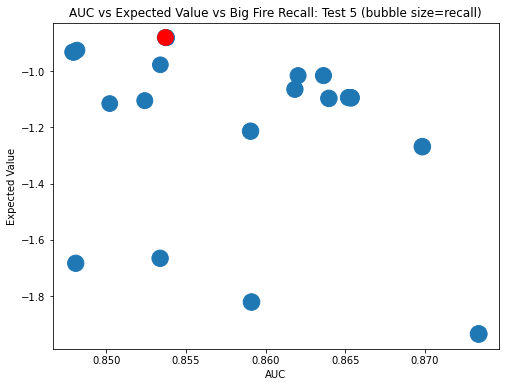

list         RF_entropy_top35_features.pkl
C                                      0.1
EV                               -0.880787
AUC                               0.853687
Recall_bf                         0.490909
Name: 0, dtype: object

In [193]:
#plot bubble chart
plt.figure(figsize=(8,6))
plt.title('AUC vs Expected Value vs Big Fire Recall: Test 5 (bubble size=recall)')
plt.xlabel('AUC')
plt.ylabel('Expected Value')
plt.scatter(t5_df['AUC'], t5_df['EV'], s=t5_df['Recall_bf']*500)
plt.scatter(t5_df.iloc[21]['AUC'], t5_df.iloc[21]['EV'], s=t5_df.iloc[21]['Recall_bf']*500, c='red')
plt.show()


t5_df.iloc[21]

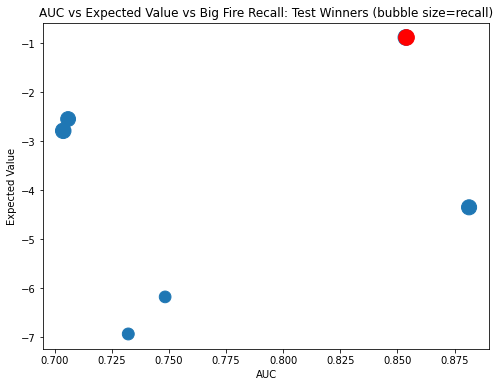

In [197]:
#plot bubble chart
plt.figure(figsize=(8,6))
plt.title('AUC vs Expected Value vs Big Fire Recall: Test Winners (bubble size=recall)')
plt.xlabel('AUC')
plt.ylabel('Expected Value')
plt.scatter(top_score_df['AUC'], top_score_df['EV'], s=top_score_df['Recall_bf']*500)
plt.scatter(top_score_df.iloc[4]['AUC'], top_score_df.iloc[4]['EV'], s=top_score_df.iloc[4]['Recall_bf']*500, c='red')
plt.show()